In [2]:
import numpy as np
from loss import *
from utils import *
import skopt
from matplotlib import pyplot as plt
from skopt import gp_minimize
import pandas as pd

## Experiments with different Bayessian Optimization approaches and Importance Sampling

For the experiments, we came up with the following methods:
1. Expected Improvement
2. Knowledge Gradient
3. Upper Confidence Bound

with each method with provide an experiments with artificial functions where loss is estimated with importance sampling.

## Setting

### Loss

Our goal is to minimize some function $f(x)$ based only on the values of the function. Here we also assume that loss has the following form

$$
L(w) = \sum_{i = 1}^N l(x_i, w)
$$

More over we know, that for some objects variation of the value is very low. We want to come with procedure where we can estimate $L$ properly computing loss only for $n$ objects, where $n << N$.

### Importance Sampling

The first attempt is importance sampling. It can be shown, that minimization of the variance guarantees the following weights in the sampling distribution. 

$$
w_i = \frac{l(x_i, w)}{\sum l(x_j, w)}
$$

Of course, we don't have access to such values. Aassuming the low variation of the $l(x_i, w)$ with respect to $w$, we can try to estimate the optimal weight by mean over all the previous observations.

### Setup

In the experiments, we will work with the following function:


We also fix the number of objects sampled. Moreover, in the practical aapplications we can automaticaly compute the optimal $n$. Look here (Lam et al. (2015), Kandasamy et al. (2016), Poloczek et al. (2017))  

### Experiment with artificial functions. 

Let consider that in reality we have 1000 objects. Each object is characterized by random vector in $R^2$. Then the loss function for each object will be computed as follows: 

$$
l(x_i, w) = 
\begin{cases}
|x_i^T w| \text{ if } Pois(|x_i^T w|) > 1 \\
0 \text{ otherwise}
\end{cases}
$$
We can see that in the following setup some objects will be irrelevant due to the low entries of $x_i$.

Study the artificial function.

In [3]:
# let see how the increasing number of evaluations approximates the true distribution
objective = LossPois()

true_distribution = sample(lambda : objective(np.array([1,2])), size=1000)

sizes = [0, 10, 40, 150, 500, 500, 1000]
approximate_distribution = np.zeros((len(sizes), len(true_distribution)))

for i in range(len(sizes)):
    for _ in range(sizes[i]):
        objective(np.array([1,2]), sample_share=0.3, update_weights=True)
        
    approximate_distribution[i] = sample(lambda : objective(np.array([1,2]), sample_share=0.3),  size=len(true_distribution))

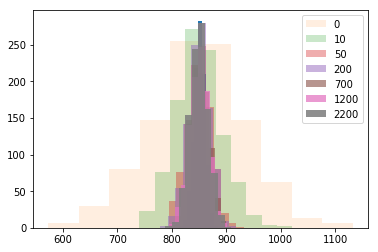

In [4]:
plt.hist(true_distribution)


history_size = np.cumsum(sizes)
for i in range(0, len(approximate_distribution)):
    row = approximate_distribution[i]
    plt.hist(row[row < 3000], alpha= (i + 1) / 8, label='{}'.format(history_size[i]))
plt.legend()
plt.show();

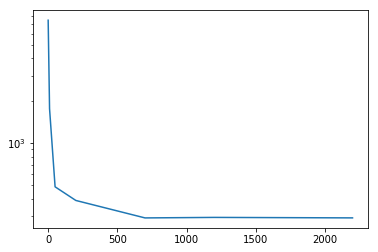

In [5]:
plt.plot(history_size,np.var(approximate_distribution, axis=1))
plt.yscale('log')
plt.show()

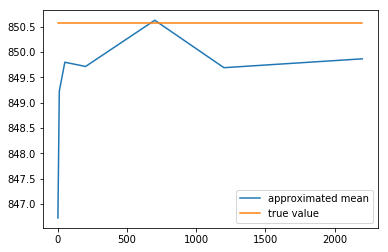

In [6]:
plt.plot(history_size, np.mean(approximate_distribution, axis =1), label='approximated mean')
plt.plot(np.array([0, 2200]), [np.mean(true_distribution), np.mean(true_distribution)], '-', label='true value')
plt.legend()
plt.show()

Not so bad! 

Let see what will happen with the random initialization of the feature vector (simulation optimization process).

In [7]:
# let see how the increasing number of evaluations approximates the true distribution
objective = LossPois()

true_distribution = sample(lambda : objective(np.array([1,2])), size=1000)

sizes = [0, 10, 40, 150, 500, 500, 1000]
approximate_distribution = np.zeros((len(sizes), len(true_distribution)))

for i in range(len(sizes)):
    for _ in range(sizes[i]):
        objective(np.random.uniform(1, 5, size=2), sample_share=0.3, update_weights=True)
        
    approximate_distribution[i] = sample(lambda : objective(np.array([1,2]), sample_share=0.3),  size=len(true_distribution))
    

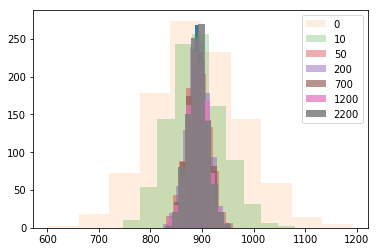

In [8]:
plt.hist(true_distribution)


history_size = np.cumsum(sizes)
for i in range(0, len(approximate_distribution)):
    row = approximate_distribution[i]
    plt.hist(row[row < 3000], alpha= (i + 1) / 8, label='{}'.format(history_size[i]))
plt.legend()
plt.show();

Setup optimization methods

### EI

In [10]:
# simple example
objective = LossPois(seed=1)
objective(np.ones(2), sample_share=1, update_weights=True)
res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=40)

In [11]:
true_values = np.zeros(len(res.x_iters))
for i in range(len(res.x_iters)):
    true_values[i] = objective(res.x_iters[i])

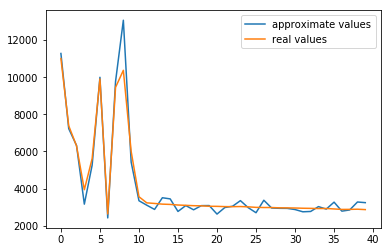

In [12]:
plt.plot(res.func_vals, label='approximate values')
plt.plot(true_values, label='real values')
plt.legend()
plt.show()

In [13]:
# comparison with/without EI
n = 300
tries = 10

different_paths = np.zeros((tries, n, 2))
different_values = np.zeros((tries, n))
different_paths_IS = np.zeros((tries, n, 2))
different_values_IS = np.zeros((tries, n))

for i in range(tries):
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_IS[i] = res.func_vals
    different_paths_IS[i] = res.x_iters
    
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=False), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values[i] = res.func_vals
    different_paths[i] = res.x_iters

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

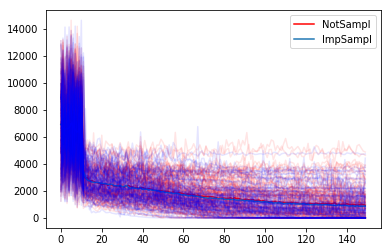

In [14]:
plt.plot(np.mean(different_values, axis=0), label='NotSampl', c='r')
for row in different_values:
    plt.plot(row, c='r',alpha=0.1)
plt.plot(np.mean(different_values_IS, axis=0), label='ImpSampl')
for row in different_values_IS:
    plt.plot(row, c='b',alpha=0.1)
plt.legend()
plt.show()

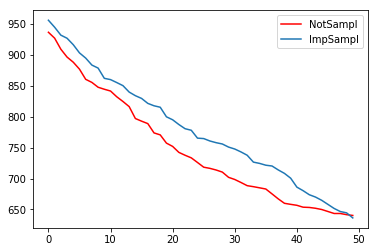

In [17]:
cum_minimas = pd.DataFrame(different_values).cummin(axis=1).values
cum_minimas_IS = pd.DataFrame(different_values_IS).cummin(axis=1).values

plt.plot(np.mean(cum_minimas, axis=0)[100:],  label='NotSampl', c='r')


plt.plot(np.mean(cum_minimas_IS, axis=0)[100:], label='ImpSampl')
plt.legend()
plt.show()

In [21]:
objective = LossPois(seed=1)

real_results = np.zeros((100, 150))
real_results_IS = np.zeros((100, 150))

for i in range(100):
    for j in range(150):
        real_results[i, j] = objective(different_paths[i, j])
        real_results_IS[i, j] = objective(different_paths_IS[i, j])


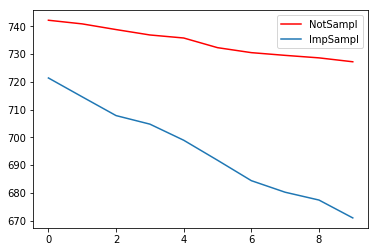

In [24]:
cum_minimas = pd.DataFrame(real_results).cummin(axis=1).values
cum_minimas_IS = pd.DataFrame(real_results_IS).cummin(axis=1).values

plt.plot(np.mean(cum_minimas, axis=0)[140:],  label='NotSampl', c='r')


plt.plot(np.mean(cum_minimas_IS, axis=0)[140:], label='ImpSampl')
plt.legend()
plt.show()

In [ ]:
# comparison with/without EI
n = 300
tries = 10

different_paths = np.zeros((tries, n, 2))
different_values = np.zeros((tries, n))
different_paths_IS = np.zeros((tries, n, 2))
different_values_IS = np.zeros((tries, n))

for i in range(tries):
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_IS[i] = res.func_vals
    different_paths_IS[i] = res.x_iters
    
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=False), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values[i] = res.func_vals
    different_paths[i] = res.x_iters

### Let estimate the variance of the mean, to demonstrate significance in the difference. 

In [55]:
cum_minimas.shape

(100, 150)

In [62]:
boot_indeces = np.random.choice(100, size=(1000, 100), replace=True)

In [75]:
print('Standard deviation of the mean:', np.std(np.mean(cum_minimas[:, -1][boot_indeces], axis = 1)))

Standard deviation of the mean: 93.012632096


### Random Search

In [ ]:
# comparison with/without EI
n = 150
tries = 100

different_paths = np.zeros((tries, n, 2))
different_values = np.zeros((tries, n))
different_paths_IS = np.zeros((tries, n, 2))
different_values_IS = np.zeros((tries, n))

for i in range(tries):
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_IS[i] = res.func_vals
    different_paths_IS[i] = res.x_iters
    
    objective = LossPois(seed=1)
    objective(np.ones(2), sample_share=1, update_weights=True)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=False), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values[i] = res.func_vals
    different_paths[i] = res.x_iters

### PI

In [41]:
# simple example
objective = LossPois(seed=1)
res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), acq_func='PI', dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=150)

In [42]:
true_values = np.zeros(len(res.x_iters))
for i in range(len(res.x_iters)):
    true_values[i] = objective(res.x_iters[i])

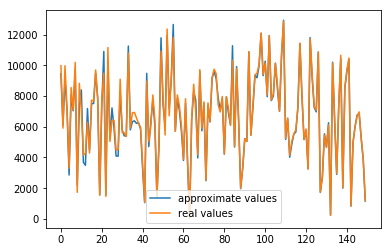

In [43]:
plt.plot(res.func_vals, label='approximate values')
plt.plot(true_values, label='real values')
plt.legend()
plt.show()

In [ ]:
# comparison with/without 

### LCP

In [44]:
# simple example
objective = LossPois(seed=1)
res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), acq_func='LCB', dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=150)

In [45]:
true_values = np.zeros(len(res.x_iters))
for i in range(len(res.x_iters)):
    true_values[i] = objective(res.x_iters[i])

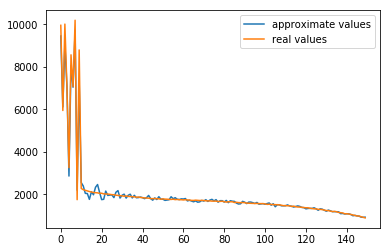

In [46]:
plt.plot(res.func_vals, label='approximate values')
plt.plot(true_values, label='real values')
plt.legend()
plt.show()

In [76]:
n = 150
tries = 100

different_paths_lsp = np.zeros((tries, n, 2))
different_values_lsp = np.zeros((tries, n))
different_paths_IS_lsp = np.zeros((tries, n, 2))
different_values_IS_lsp = np.zeros((tries, n))

for i in range(tries):
    objective = LossPois(seed=1)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), acq_func='LCB', dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_IS_lsp[i] = res.func_vals
    different_paths_IS_lsp[i] = res.x_iters
    
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=False), acq_func='LCB', dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_lsp[i] = res.func_vals
    different_paths_lsp[i] = res.x_iters

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

In [77]:
cum_minimas = pd.DataFrame(different_values_lsp).cummin(axis=1).values
cum_minimas_IS = pd.DataFrame(different_values_IS_lsp).cummin(axis=1).values

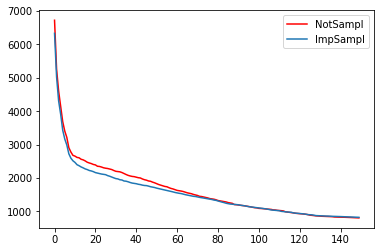

In [81]:
plt.plot(np.mean(cum_minimas, axis=0),  label='NotSampl', c='r')

plt.plot(np.mean(cum_minimas_IS, axis=0), label='ImpSampl')
plt.legend()
plt.show()

# Second loss optimization

In [3]:
# let see how the increasing number of evaluations approximates the true distribution
objective = LossUniform()

true_distribution = sample(lambda : objective(np.array([1,2])), size=1000)

sizes = [0, 10, 40, 150, 500, 500, 1000]
approximate_distribution = np.zeros((len(sizes), len(true_distribution)))

for i in range(len(sizes)):
    for _ in range(sizes[i]):
        objective(np.array([1,2]), sample_share=0.3, update_weights=True)
        
    approximate_distribution[i] = sample(lambda : objective(np.array([1,2]), sample_share=0.3),  size=len(true_distribution))

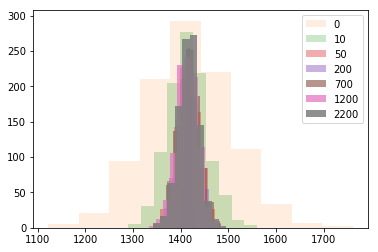

In [4]:
plt.hist(true_distribution)

history_size = np.cumsum(sizes)
for i in range(0, len(approximate_distribution)):
    row = approximate_distribution[i]
    plt.hist(row[row < 3000], alpha= (i + 1) / 8, label='{}'.format(history_size[i]))
plt.legend()
plt.show();

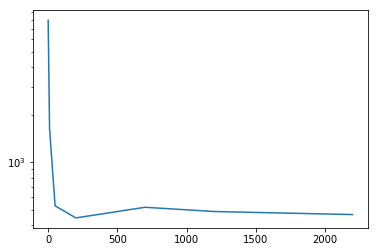

In [5]:
plt.plot(history_size,np.var(approximate_distribution, axis=1))
plt.yscale('log')
plt.show()

# EI

In [6]:
# simple example
objective = LossUniform(seed=1)
res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=40)

In [7]:
true_values = np.zeros(len(res.x_iters))
for i in range(len(res.x_iters)):
    true_values[i] = objective(res.x_iters[i])

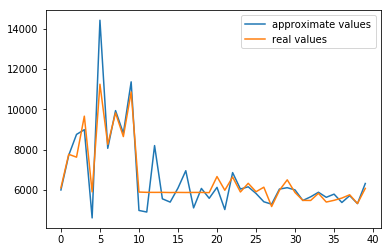

In [8]:
plt.plot(res.func_vals, label='approximate values')
plt.plot(true_values, label='real values')
plt.legend()
plt.show()

In [9]:
# comparison with/without EI
n = 150
tries = 100

different_paths = np.zeros((tries, n, 2))
different_values = np.zeros((tries, n))
different_paths_IS = np.zeros((tries, n, 2))
different_values_IS = np.zeros((tries, n))

for i in range(tries):
    objective = LossUniform(seed=1)
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=True), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values_IS[i] = res.func_vals
    different_paths_IS[i] = res.x_iters
    
    res = gp_minimize(func=lambda x: objective(x, sample_share=0.3, update_weights=False), dimensions=[(0.0, 20.0), (0.0, 20.0)], n_calls=n, random_state=i)
    different_values[i] = res.func_vals
    different_paths[i] = res.x_iters

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pac

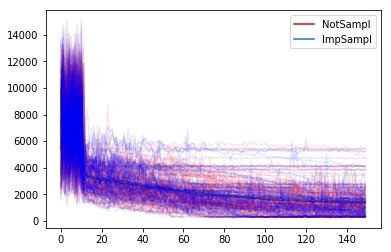

In [11]:
plt.plot(np.mean(different_values, axis=0), label='NotSampl', c='r')
for row in different_values:
    plt.plot(row, c='r',alpha=0.1)
plt.plot(np.mean(different_values_IS, axis=0), label='ImpSampl')
for row in different_values_IS:
    plt.plot(row, c='b',alpha=0.1)
plt.legend()
plt.show()

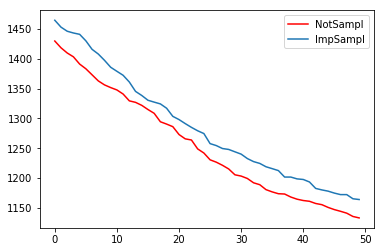

In [10]:
cum_minimas = pd.DataFrame(different_values).cummin(axis=1).values
cum_minimas_IS = pd.DataFrame(different_values_IS).cummin(axis=1).values

plt.plot(np.mean(cum_minimas, axis=0)[100:],  label='NotSampl', c='r')


plt.plot(np.mean(cum_minimas_IS, axis=0)[100:], label='ImpSampl')
plt.legend()
plt.show()